# Shallow Neural Network (Planar Data Classification with one Hidden Layer)

**We will do the following:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation

## 1 - Include the required packages

Let's take care of the packages that we will be needing for this one hidden layer neural network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline
np.random.seed(1)

## 2 - Get the dataset

Let's take the dataset. There are two classes in the dataset for which we need to build the classification
algorithm.

In [50]:
#X, Y = load_planar_dataset()
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

The shape of the data is as follows, let's visualize the dataset using matplotlib.
1. X = (2, 400)
2. Y = (1, 400)

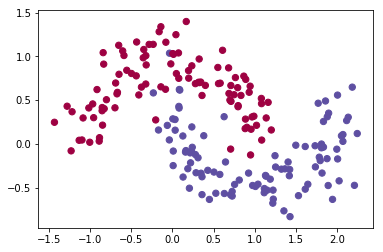

In [51]:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral)

We have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).
    - 400 training examples
    - two class classification between red and blue

## 3 - How logistic regression would have performed
Before jumping on to developing the neural network to solve this problem let's see how logistic regression would have performed on this dataset. We will do this to give an intuition about the non-linearity of the problem. Instead of making our own logistic regression let's use sklearn's built in logistic regression to save time.

In [52]:
#training the logistic regression classifier.
classifier = sklearn.linear_model.LogisticRegressionCV(cv = 3)
classifier.fit(X.T, Y.ravel().T)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Accuracy of logistic regression: 87 % (percentage of correctly labelled datapoints)


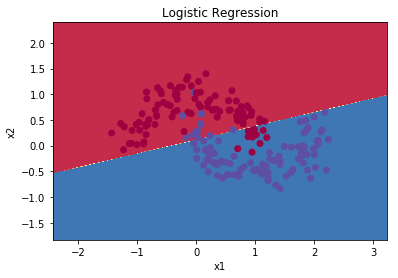

In [53]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: classifier.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = classifier.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

The data is not linearly separable, so logistic regression is not performing well for this. Let's try to build a neural network for this.

## 4 - Neural Network Model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

For building the neural network we need to do some things:
1. Get the architecture of the neural network
    - set up the number of layers
    - number of neurons in each layer
2. Initialize the parameters of the neural network
3. Do the forward propagation to calculate current cost on the current parameters
4. Do the backward propagation to calculate the error
5. Optimize using gradient descent and calculate the new parameters.
6. Predict with the test data


### 4.1 - Neural network architecture

let's setup the layers first.

In [36]:
def define_layer_sizes(X, Y):
    #let'd define the size of the input, hidden and output layers
    #the size of the input layer will obviously depend on the dataset for this example
    
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)

Now when the architecture has been coded, let's initialize the parameters of the network that we have to
learn. The size of these parameters will depend on the size of the layers. Obviously.

### 4.2 - Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [37]:
def initialize_parameters(n_x, n_h, n_y):
    #we will have four parameters here
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(2)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1" : W1,
                 "b1" : b1,
                 "W2" : W2,
                 "b2" : b2}
    
    return parameters
    

Now that we have initialized the parameters, let's compute the forward propagation step. Let's calculate the activations in the forward_propagation function below.

### 4.3 - The Loop ####

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [38]:
def forward_propagation(X, parameters):
    
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }
    
    return A2, cache

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. To help you, we give you how we would have implemented
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(you can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).


In [39]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    
    cost = -((np.sum(Y * np.log(A2) + (1-Y) * np.log(1 - A2)))/m)
    cost = np.squeeze(cost) 
    
    return cost

Using the cache computed during forward propagation, we can now implement backward propagation.

Backpropagation is usually the hardest (most mathematical) part in deep learning. We'll use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [40]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    
    m = X.shape[1]
    
    #let's take the parameters
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    #after taking the parameters lets calculate the derivatives
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Question**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [41]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    #let's take the parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #let's take the derivatives/gradients
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    #let's update the parameters
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [54]:
def nn_model(X, Y, n_h, num_iterations = 10000):
    
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    costs = []
    np.random.seed(3)
    
    n_x = define_layer_sizes(X, Y)[0]
    n_y = define_layer_sizes(X, Y)[2]
    
    #initialize the parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        
        #forward propagation
        A2, cache = forward_propagation(X, parameters)
        
        #calculate the current cost
        cost = compute_cost(A2, Y, parameters)
        costs.append(cost)
        
        #backward propagation
        grads = backward_propagation(parameters, cache, X, Y)
        
        #updated parameters
        parameters = update_parameters(parameters, grads)
        
        if i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
            
    
    return parameters, costs

        
        
    

In [55]:
X_assess, Y_assess = nn_model_test_case()
parameters, costs = nn_model(X_assess, Y_assess, 4, num_iterations=10000)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]


In [56]:
def predict(parameters, X):
    
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    
    return predictions

In [57]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


Cost after iteration 0: 0.692992
Cost after iteration 1000: 0.167137
Cost after iteration 2000: 0.069092
Cost after iteration 3000: 0.063716
Cost after iteration 4000: 0.061312
Cost after iteration 5000: 0.059669
Cost after iteration 6000: 0.058364
Cost after iteration 7000: 0.057279
Cost after iteration 8000: 0.056359
Cost after iteration 9000: 0.055569


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

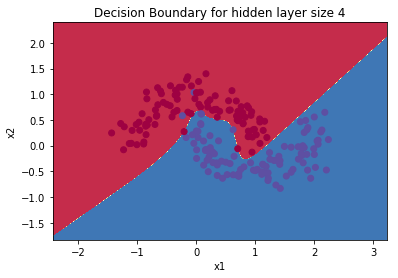

In [58]:
# Build a model with a n_h-dimensional hidden layer
parameters, costs = nn_model(X, Y, n_h = 4, num_iterations = 10000)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

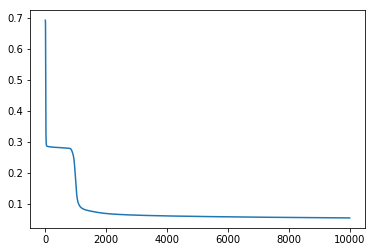

In [59]:
plt.plot(costs)

In [60]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 98%


Cost after iteration 0: 0.693127
Cost after iteration 1000: 0.291739
Cost after iteration 2000: 0.291847
Cost after iteration 3000: 0.291850
Cost after iteration 4000: 0.291850
Accuracy for 1 hidden units: 86.5 %
Cost after iteration 0: 0.693059
Cost after iteration 1000: 0.279311
Cost after iteration 2000: 0.278108
Cost after iteration 3000: 0.277626
Cost after iteration 4000: 0.277274
Accuracy for 2 hidden units: 87.0 %
Cost after iteration 0: 0.693015
Cost after iteration 1000: 0.278801
Cost after iteration 2000: 0.083100
Cost after iteration 3000: 0.076277
Cost after iteration 4000: 0.074405
Accuracy for 3 hidden units: 97.0 %
Cost after iteration 0: 0.692992
Cost after iteration 1000: 0.167137
Cost after iteration 2000: 0.069092
Cost after iteration 3000: 0.063716
Cost after iteration 4000: 0.061312
Accuracy for 4 hidden units: 98.5 %
Cost after iteration 0: 0.693395
Cost after iteration 1000: 0.278603
Cost after iteration 2000: 0.277449
Cost after iteration 3000: 0.276908
Cost af

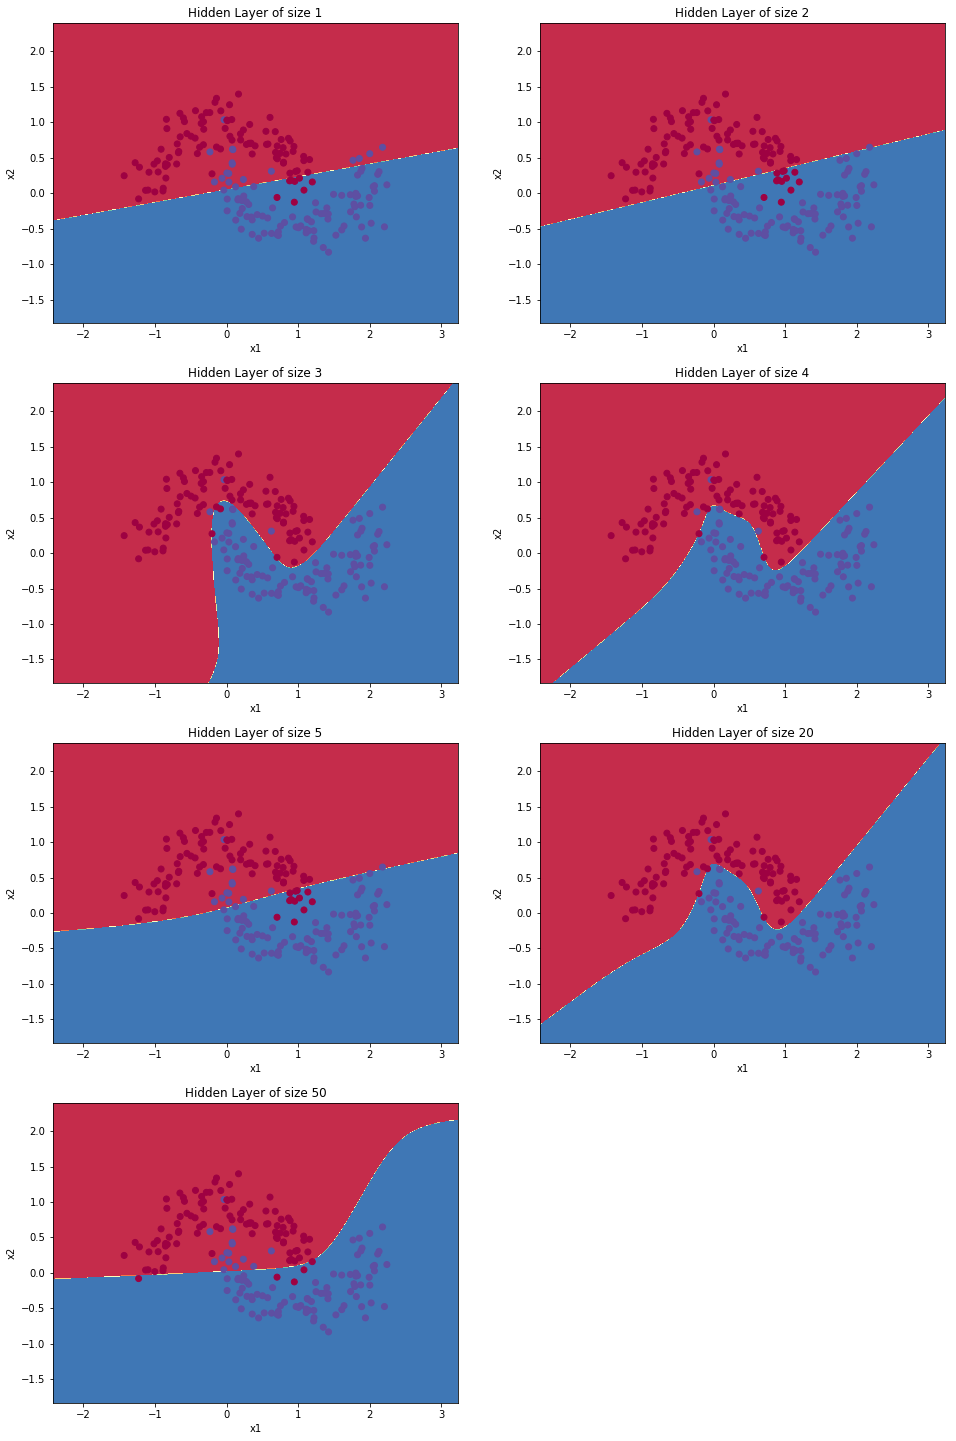

In [61]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters, costs = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))